In [26]:
!pip install lime

In [27]:
!pip install shap

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import lime.lime_tabular
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings

In [29]:
warnings.filterwarnings("ignore")

In [30]:
df = pd.read_csv("/kaggle/input/network-traffic-data-for-gps-spoofing/GPS Spoofing Attack Detection Dataset for Network Traffic Analysis.csv")

In [31]:
print("Dataset Shape:", df.shape)
print("First 5 Rows:\n", df.head())

Dataset Shape: (25192, 42)
First 5 Rows:
    duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  25   
1               0       0    0  ...                   1   
2               0       0    0  ...                  26   
3               0       0    0  ...                 255   
4               0       0    0  ...                 255   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.17                    0.03   
1                    0.00                    0.60   
2          

In [32]:
categorical_cols = ['protocol_type', 'service', 'flag', 'class']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [33]:
print("\nMissing Values:\n", df.isnull().sum())



Missing Values:
 duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate            

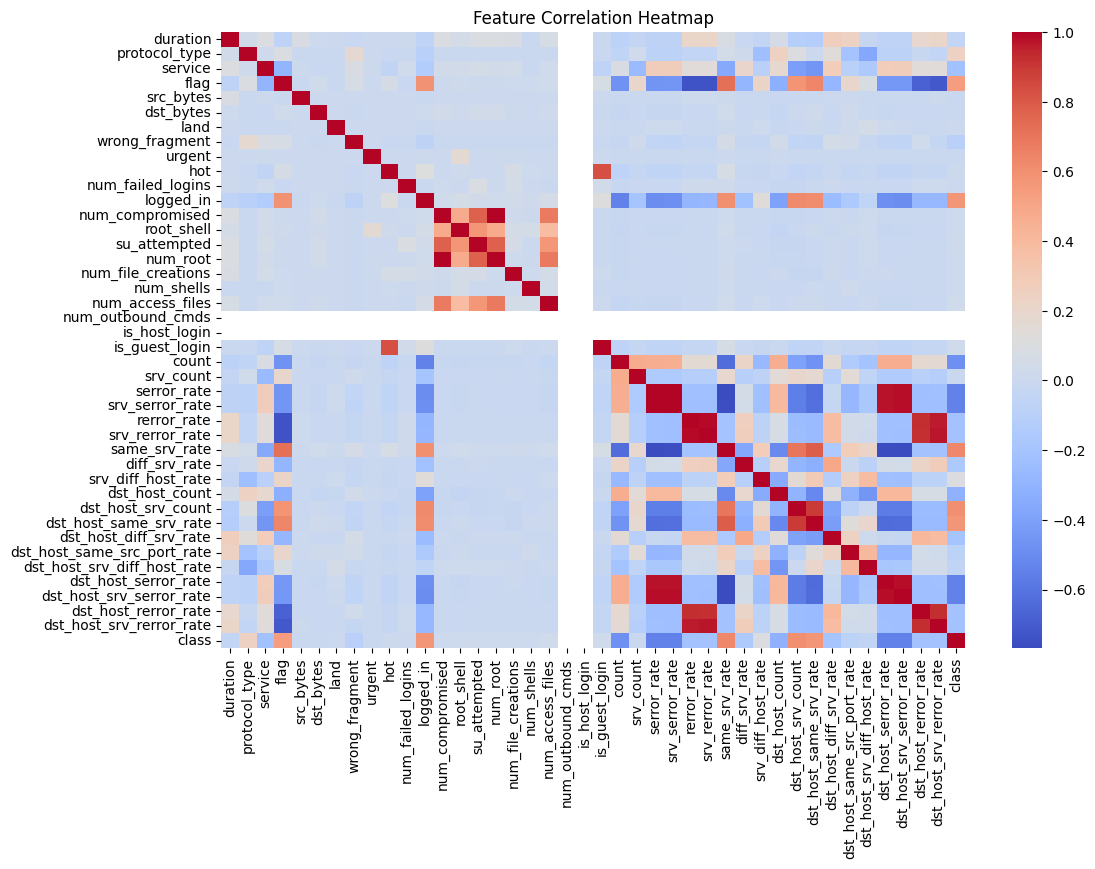

In [34]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

In [35]:
X = df.drop(columns=['class'])
y = df['class']

In [36]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [38]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\nRandom Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nRandom Forest Classification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.6221472514387776

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.20      0.21      0.20       475
           1       0.18      0.19      0.19       469
           2       0.22      0.19      0.21       495
           3       0.21      0.21      0.21       458
           4       0.17      0.18      0.18       468
           5       0.99      1.00      1.00      2674

    accuracy                           0.62      5039
   macro avg       0.33      0.33      0.33      5039
weighted avg       0.62      0.62      0.62      5039



In [39]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("\nXGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nXGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))


XGBoost Accuracy: 0.6247271283984918

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.20      0.21      0.20       475
           1       0.20      0.18      0.19       469
           2       0.23      0.22      0.23       495
           3       0.20      0.18      0.19       458
           4       0.18      0.22      0.20       468
           5       1.00      1.00      1.00      2674

    accuracy                           0.62      5039
   macro avg       0.33      0.33      0.33      5039
weighted avg       0.62      0.62      0.62      5039



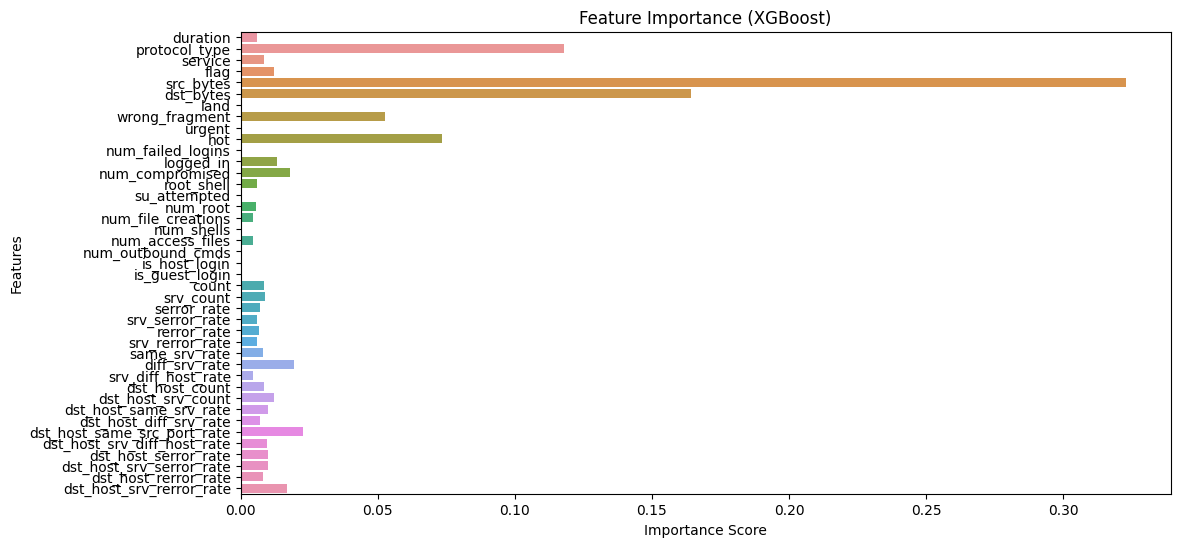

In [40]:
plt.figure(figsize=(12, 6))
sns.barplot(x=xgb.feature_importances_, y=X.columns)
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

In [42]:
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, validation_data=(X_test_reshaped, y_test))

Epoch 1/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 26s 36ms/step - accuracy: 0.0930 - loss: -374.3716 - val_accuracy: 0.0931 - val_loss: -2824.3462
Epoch 2/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.0934 - loss: -4418.2417 - val_accuracy: 0.0931 - val_loss: -10351.8047
Epoch 3/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.0899 - loss: -13026.5352 - val_accuracy: 0.0931 - val_loss: -21787.8652
Epoch 4/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.0919 - loss: -25381.3574 - val_accuracy: 0.0931 - val_loss: -36584.4648
Epoch 5/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.0877 - loss: -41224.5625 - val_accuracy: 0.0931 - val_loss: -54287.0430
Epoch 6/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.0896 - loss: -59465.0352 - val_accuracy: 0.0931 - val_loss: -74713.5234
Epoch 7/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.0933 - loss: -80854.7812 - val_accuracy: 0.0931 - val_loss: -97657.1484
Epoch 8/100
630/6

In [50]:
y_pred_lstm = (model.predict(X_test_reshaped) > 0.5).astype(int)
print("\nLSTM Accuracy:", accuracy_score(y_test, y_pred_lstm))
print("\nLSTM Classification Report:\n", classification_report(y_test, y_pred_lstm))


158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step

LSTM Accuracy: 0.09307402262353641

LSTM Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       475
           1       0.09      1.00      0.17       469
           2       0.00      0.00      0.00       495
           3       0.00      0.00      0.00       458
           4       0.00      0.00      0.00       468
           5       0.00      0.00      0.00      2674

    accuracy                           0.09      5039
   macro avg       0.02      0.17      0.03      5039
weighted avg       0.01      0.09      0.02      5039



In [51]:
explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)

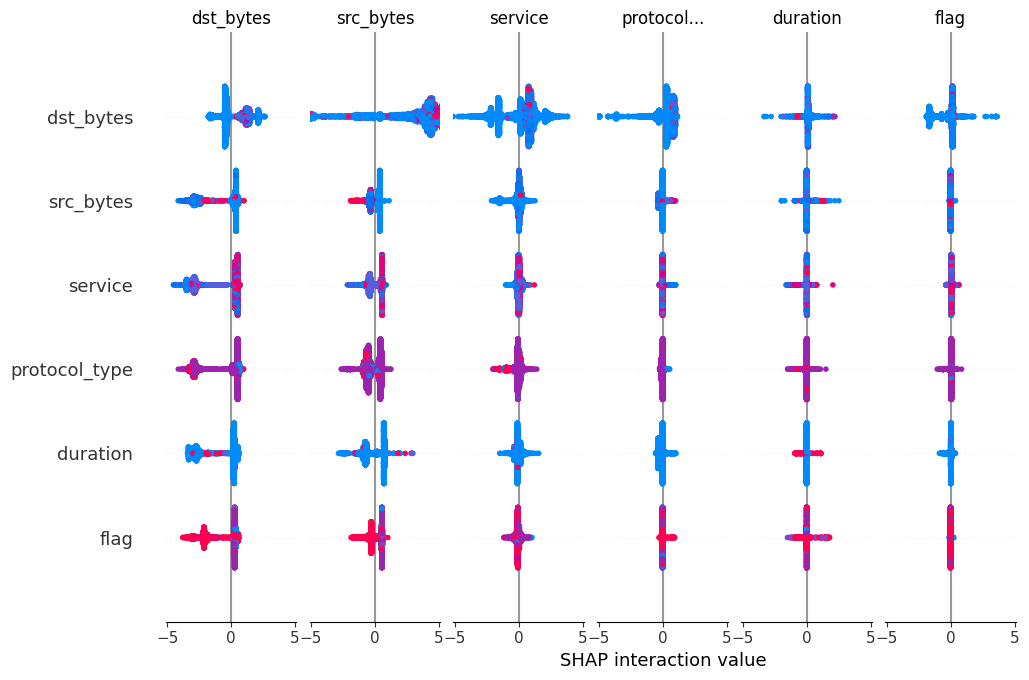

In [52]:
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

In [53]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=X.columns,
    class_names=["Normal", "Attack"],
    mode="classification"
)

sample_idx = np.random.randint(0, X_test.shape[0])
sample = X_test[sample_idx]

lime_exp = lime_explainer.explain_instance(sample, xgb.predict_proba)
lime_exp.show_in_notebook()
